# Quantum SVM

## Import data

Lets start off by reading in our data

In [18]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42

sns.set(style='whitegrid', context='notebook')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# Get dataset from Kaggle
path = kagglehub.dataset_download("nabihazahid/spotify-dataset-for-churn-analysis")

# Load dataset into DataFrame
df = pd.read_csv(path + "\\spotify_churn_dataset.csv", low_memory=False, index_col=0)
df.reset_index(drop=True, inplace=True)
df.head()

,gender,age,country,subscription_type,listening_time,songs_played_per_day,skip_rate,device_type,ads_listened_per_week,offline_listening,is_churned
0,Female,54,CA,Free,26,23,0.20,Desktop,31,0,1
1,Other,33,DE,Family,141,62,0.34,Web,0,1,0
2,Male,38,AU,Premium,199,38,0.04,Mobile,0,1,1
3,Female,22,CA,Student,36,2,0.31,Mobile,0,1,0
4,Other,29,US,Family,250,57,0.36,Mobile,0,1,1


## EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gender                 8000 non-null   object 
 1   age                    8000 non-null   int64  
 2   subscription_type      8000 non-null   object 
 3   listening_time         8000 non-null   int64  
 4   songs_played_per_day   8000 non-null   int64  
 5   skip_rate              8000 non-null   float64
 6   ads_listened_per_week  8000 non-null   int64  
 7   is_churned             8000 non-null   int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 500.1+ KB


In [5]:
df.describe()

,age,listening_time,songs_played_per_day,skip_rate,ads_listened_per_week,is_churned
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,37.662125,154.068250,50.127250,0.300127,6.943875,0.258875
std,12.740359,84.015596,28.449762,0.173594,13.617953,0.438044
min,16.000000,10.000000,1.000000,0.000000,0.000000,0.000000
25%,26.000000,81.000000,25.000000,0.150000,0.000000,0.000000
50%,38.000000,154.000000,50.000000,0.300000,0.000000,0.000000
75%,49.000000,227.000000,75.000000,0.450000,5.000000,1.000000
max,59.000000,299.000000,99.000000,0.600000,49.000000,1.000000


## Preproccessing

In [6]:
# check if the variable is categorical or numerical
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# now we can encode categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Feature-target split
X = df.drop('is_churned', axis=1) 
y = df['is_churned']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

X_train

array([[ 1.22893058e+00, -5.19739178e-02, -1.37415163e+00, ...,
        -1.09928703e-01,  6.90576263e-01, -5.09937786e-01],
       [-1.22616859e+00,  6.54486735e-01,  1.34581861e+00, ...,
         1.71286301e-01, -1.67140224e+00, -5.09937786e-01],
       [ 1.38099329e-03, -1.15091271e+00, -1.37415163e+00, ...,
        -2.50536205e-01, -2.31171444e-01, -5.09937786e-01],
       ...,
       [ 1.38099329e-03,  6.54486735e-01,  1.34581861e+00, ...,
         3.47045679e-01,  5.68747140e-02, -5.09937786e-01],
       [-1.22616859e+00, -1.62188648e+00, -1.37415163e+00, ...,
         2.76741928e-01,  1.20905935e+00, -5.09937786e-01],
       [ 1.22893058e+00,  1.12546050e+00,  1.34581861e+00, ...,
        -1.58630747e+00, -1.44096531e+00, -5.09937786e-01]],
      shape=(6400, 7))

## PCA

QSVC is a computationally intensive algorithm, and as such it makes sense to reduce the number of dimensions to get better runtime. Here we will use PCA, which is a common dimensionality reduction technique.

In [16]:
from sklearn.decomposition import PCA

PCA_COMPONENTS = 7

pca = PCA(n_components=PCA_COMPONENTS)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

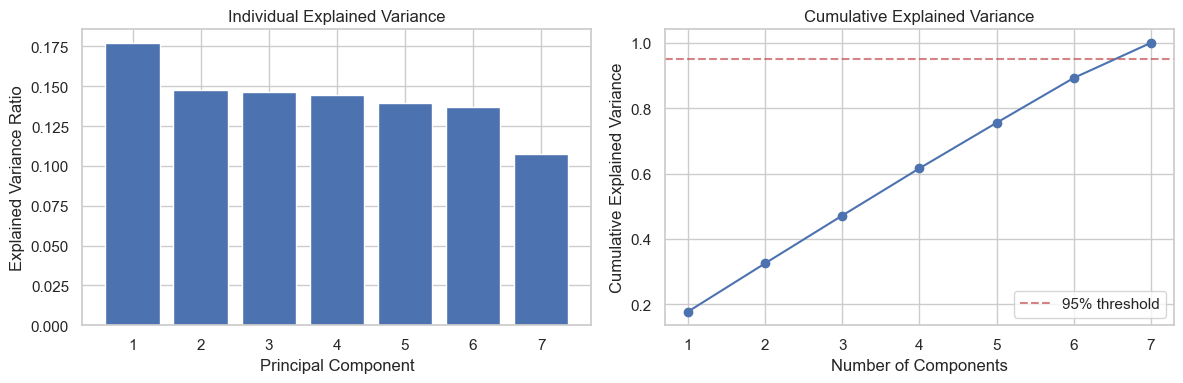

In [17]:
explained_var_ratio = pca.explained_variance_ratio_
cumulative_var_ratio = np.cumsum(explained_var_ratio)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.bar(range(1, len(explained_var_ratio) + 1), explained_var_ratio)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Individual Explained Variance')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_var_ratio) + 1), cumulative_var_ratio, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', alpha=0.7, label='95% threshold')
plt.legend()

plt.tight_layout()
plt.show()

## SVC

We will first train a classical SVC model to get a baseline accuracy score. Then we will run a grid search to ensure we have the best hyperparameters.

In [41]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import time

class_weight = {0: df.shape[0] / (2 * (df.shape[0] - df['is_churned'].sum())), 1: df.shape[0] / (2 * df['is_churned'].sum())}

baseline_svc = SVC(class_weight=class_weight, random_state=RANDOM_STATE)

start_time = time.time()
baseline_svc.fit(X_train_pca, y_train)
training_time = time.time() - start_time

# Predictions
y_pred = baseline_svc.predict(X_test_pca)
y_pred_proba = baseline_svc.decision_function(X_test_pca)

# Evaluation
print(f"Training time: {training_time:.2f} seconds")
print(f"Test accuracy: {baseline_svc.score(X_test_pca, y_test):.4f}")

# Cross-validation
cv_scores = cross_val_score(baseline_svc, X_train_pca, y_train, cv=5)
print(f"Cross-validation accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Training time: 1.23 seconds
Test accuracy: 0.5181
Cross-validation accuracy: 0.5100 (+/- 0.0471)


### Grid Search

We will use a grid search to find the best hyperparameters for our SVC model.

In [42]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 0.01]
}
cv_folds = 3

svc = SVC(class_weight=class_weight, random_state=RANDOM_STATE)
        
# Set up a grid search
grid_search = GridSearchCV(
    svc, param_grid, cv=cv_folds, 
    scoring='accuracy', n_jobs=-1, verbose=1
)

start_time = time.time()
grid_search.fit(X_train_pca, y_train)
tuning_time = time.time() - start_time

best_params = grid_search.best_params_
model = grid_search.best_estimator_

# print results
print(f"Hyperparameter tuning time: {tuning_time:.2f} seconds")
print(f"Best parameters: {best_params}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Hyperparameter tuning time: 4.40 seconds
Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score: 0.5064


### Final SVC Model

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.53      0.62      1200
           1       0.26      0.49      0.34       400

    accuracy                           0.52      1600
   macro avg       0.51      0.51      0.48      1600
weighted avg       0.63      0.52      0.55      1600



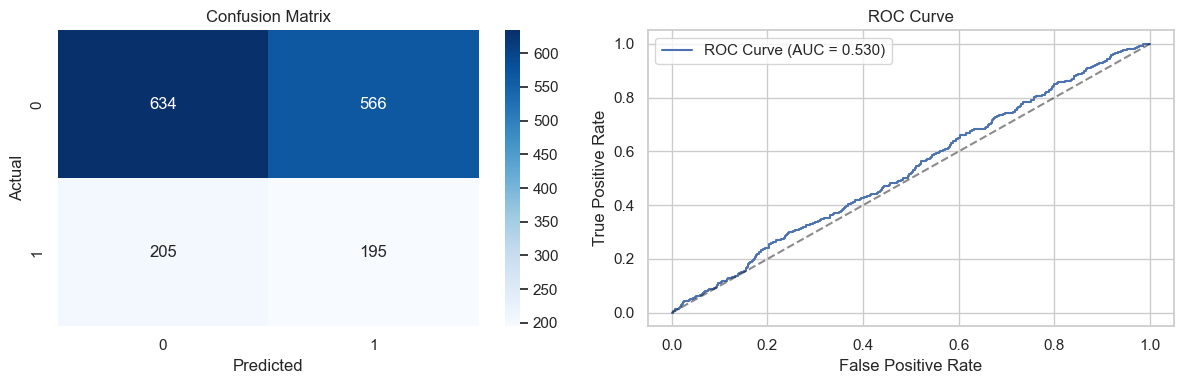

In [43]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

model = SVC(**best_params,
            class_weight=class_weight
            ,random_state=RANDOM_STATE)

model.fit(X_train_pca, y_train)

y_pred = model.predict(X_test_pca)
y_pred_proba = model.decision_function(X_test_pca)

# Classification metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# ROC Curve
plt.subplot(1, 2, 2)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.tight_layout()
plt.show()

## QSVC

In [44]:
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

feature_map = PauliFeatureMap(
                            feature_dimension=PCA_COMPONENTS, 
                            reps=1, 
                            paulis=['Z', 'ZZ'])

sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

adhoc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

In [ ]:
from qiskit_machine_learning.algorithms import QSVC
import time

qsvc = QSVC(quantum_kernel=adhoc_kernel)

start_time = time.time()
qsvc.fit(X_train_pca[:100], y_train[:100])
end_time = time.time()

qsvc_score = qsvc.score(X_test_pca, y_test)

print(f"Training took {end_time - start_time:.2f} seconds")
print(f"QSVC classification test score: {qsvc_score}")